## Neural Network Time Baby

In [29]:
# pip install torch torchvision torchaudio (if needed)
import os, random, numpy as np, pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from pathlib import Path
import cv2

cv2.setNumThreads(0)  # avoids OpenCV thread conflicts

NUM_WORKERS = 0  # <-- critical on Windows notebooks
PIN_MEMORY = (torch.cuda.is_available())

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 8
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if DEVICE.type == "cuda": torch.cuda.manual_seed_all(SEED)


## Sample Images

In [30]:
IMAGE_ROOT = Path("FracAtlas") / "images"
POS_DIR = IMAGE_ROOT / "Fractured"
NEG_DIR = IMAGE_ROOT / "Non_fractured"

print("POS_DIR:", POS_DIR.resolve(), "exists?", POS_DIR.exists())
print("NEG_DIR:", NEG_DIR.resolve(), "exists?", NEG_DIR.exists())

pos_sample = [str(p) for p in POS_DIR.rglob("*") if p.suffix.lower() == ".jpg"][:5]
neg_sample = [str(p) for p in NEG_DIR.rglob("*") if p.suffix.lower() == ".jpg"][:5]

print("Fractured sample:", pos_sample)
print("Non-fractured sample:", neg_sample)

def list_jpgs(root: Path):
    return sorted(str(p) for p in root.rglob("*.jpg")) + \
           sorted(str(p) for p in root.rglob("*.JPG"))

pos_files = list_jpgs(POS_DIR)
neg_files = list_jpgs(NEG_DIR)
print('Found', len(pos_files), 'fractured and', len(neg_files), 'non-fractured images')
# assumes pos_files (fractured) and neg_files (non-fractured) already built from your dirs


N_POS, N_NEG = 100, 100
pos_sel = random.sample(pos_files, k=min(N_POS, len(pos_files)))
neg_sel = random.sample(neg_files, k=min(N_NEG, len(neg_files)))

work_df = pd.DataFrame({
    "image_path": pos_sel + neg_sel,
    "label": [1]*len(pos_sel) + [0]*len(neg_sel),
}).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print(work_df['label'].value_counts())


POS_DIR: C:\Users\rohan\Duke Stuff\BME790\Bone-Fracture-AI-Analysis\FracAtlas\images\Fractured exists? True
NEG_DIR: C:\Users\rohan\Duke Stuff\BME790\Bone-Fracture-AI-Analysis\FracAtlas\images\Non_fractured exists? True
Fractured sample: ['FracAtlas\\images\\Fractured\\IMG0000019.jpg', 'FracAtlas\\images\\Fractured\\IMG0000025.jpg', 'FracAtlas\\images\\Fractured\\IMG0000044.jpg', 'FracAtlas\\images\\Fractured\\IMG0000057.jpg', 'FracAtlas\\images\\Fractured\\IMG0000058.jpg']
Non-fractured sample: ['FracAtlas\\images\\Non_fractured\\IMG0000000.jpg', 'FracAtlas\\images\\Non_fractured\\IMG0000001.jpg', 'FracAtlas\\images\\Non_fractured\\IMG0000002.jpg', 'FracAtlas\\images\\Non_fractured\\IMG0000003.jpg', 'FracAtlas\\images\\Non_fractured\\IMG0000004.jpg']
Found 1434 fractured and 6732 non-fractured images
label
1    100
0    100
Name: count, dtype: int64


In [31]:
# 1) Locate and read dataset.csv (adjust path if needed)
# Try common locations; set csv_path directly if different.
candidates = [
    Path("FracAtlas") / "dataset.csv",
    Path("./dataset.csv"),
    Path("FracAtlas/dataset.csv"),
]
csv_path = None
for c in candidates:
    if c.exists():
        csv_path = c; break

if csv_path is None:
    raise FileNotFoundError("Could not find dataset.csv. Set csv_path to its location.")

meta = pd.read_csv(csv_path)

# work_df already has full paths; create a basename for join
def base_only(p): 
    return os.path.basename(p)

work_df["filename"] = work_df["image_path"].apply(base_only)

# Your CSV uses 'image_id' like 'IMG0000000.jpg'
if "image_id" in meta.columns:
    meta["filename"] = meta["image_id"].apply(lambda s: os.path.basename(str(s)))
elif "image" in meta.columns:
    meta["filename"] = meta["image"].apply(lambda s: os.path.basename(str(s)))
elif "filename" in meta.columns:
    # already good
    pass
else:
    raise KeyError("dataset.csv must have one of: image_id, image, or filename")

# Select prior columns (present in your CSV)
CANDIDATE_PRIORS = [
    "hand","leg","hip","shoulder",          # anatomy
    "frontal","lateral","oblique",          # view
    "hardware","multiscan","mixed",         # confounders
    "elbow","wrist","forearm"               # include if present
]
prior_cols = [c for c in CANDIDATE_PRIORS if c in meta.columns]

# Never include target/leaky columns
for leak in ["fractured", "fracture_count", "label", "target", "class"]:
    if leak in prior_cols:
        prior_cols.remove(leak)

# Merge priors into your 200-row work_df
meta_priors = meta[["filename"] + prior_cols].copy()
work_df = work_df.merge(meta_priors, on="filename", how="left")

# Fill NA priors with 0 and cast
for c in prior_cols:
    work_df[c] = work_df[c].fillna(0).astype("float32")

print("Using prior columns:", prior_cols)

Using prior columns: ['hand', 'leg', 'hip', 'shoulder', 'frontal', 'lateral', 'oblique', 'hardware', 'multiscan', 'mixed']


## Backgorund Supress and Loading

In [32]:
TARGET_SIZE = 512  # as you requested

def pad_to_square(img):
    h, w = img.shape
    s = max(h, w)
    pt = (s - h)//2; pb = s - h - pt
    pl = (s - w)//2; pr = s - w - pl
    return cv2.copyMakeBorder(img, pt, pb, pl, pr, borderType=cv2.BORDER_REFLECT_101)

def bg_suppress_and_stretch_numpy(img_u8, t=20):
    img16 = img_u8.astype(np.int16)
    body  = img16 > t
    out   = np.zeros_like(img16, dtype=np.uint8)
    hi = t + 1
    if hi < 255 and body.any():
        scale = 254.0 / (255 - hi)
        vals = img16[body]
        out_vals = 1 + np.round((vals - hi) * scale)
        out[body] = np.clip(out_vals, 1, 255).astype(np.uint8)
    return out

class FracAtlasDSPriors(Dataset):
    def __init__(self, df, prior_cols, augment=False):
        self.df = df.reset_index(drop=True)
        self.prior_cols = prior_cols
        self.augment = augment
        self.t_train = transforms.Compose([
            transforms.RandomResizedCrop(TARGET_SIZE, scale=(0.85, 1.0)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.25]*3),
        ])
        self.t_eval = transforms.Compose([
            transforms.Resize(TARGET_SIZE),
            transforms.CenterCrop(TARGET_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.25]*3),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        p = self.df.loc[i, "image_path"]
        y = int(self.df.loc[i, "label"])

        # robust load
        try:
            img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
            if img is None:
                raise ValueError("cv2.imread returned None")
            img = pad_to_square(img)
            img = cv2.resize(img, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_AREA)
            img = bg_suppress_and_stretch_numpy(img, t=20)
        except Exception as e:
            print(f"[WARN] Failed to read/process {p}: {e}")
            img = np.zeros((TARGET_SIZE, TARGET_SIZE), np.uint8)

        # to 3-channel PIL for torchvision
        img3 = np.stack([img, img, img], axis=-1)
        pil  = Image.fromarray(img3)
        x    = self.t_train(pil) if self.augment else self.t_eval(pil)

        # prior vector
        tab = self.df.loc[i, self.prior_cols].values.astype("float32")
        tab = torch.tensor(tab, dtype=torch.float32)

        return x, tab, torch.tensor(y, dtype=torch.long)

## ResNet-18 Model with Transfer Learning and Priors

In [33]:
def make_model():
    m = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    m.fc = nn.Linear(m.fc.in_features, 1)  # binary logit
    return m.to(DEVICE)



class ResNet18WithPriors(nn.Module):
    def __init__(self, tab_dim):
        super().__init__()
        # Image backbone (ImageNet weights)
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        feat_dim = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()             # 512-D embedding

        self.img_head = nn.Sequential(
            nn.Linear(feat_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )
        self.tab_head = nn.Sequential(
            nn.Linear(tab_dim, 32),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
        )
        self.classifier = nn.Linear(256 + 32, 1)     # binary logit

    def forward(self, x_img, x_tab):
        feats = self.backbone(x_img)                 # (B,512)
        imgf  = self.img_head(feats)                 # (B,256)
        tabf  = self.tab_head(x_tab)                 # (B,32)
        z     = torch.cat([imgf, tabf], dim=1)       # (B,288)
        logit = self.classifier(z).squeeze(1)        # (B,)
        return logit

def set_trainable(model, train_backbone=False):
    # freeze all
    for p in model.parameters(): p.requires_grad = False
    # always train fusion heads + classifier
    for p in model.img_head.parameters(): p.requires_grad = True
    for p in model.tab_head.parameters(): p.requires_grad = True
    for p in model.classifier.parameters(): p.requires_grad = True
    # optional: unfreeze last conv block in image backbone
    if train_backbone:
        for p in model.backbone.layer4.parameters(): p.requires_grad = True


## 5 Fold CV using out of fold metrics

In [34]:
def train_one_epoch(model, loader, opt, loss_fn):
    model.train(); tot=0; run=0.0
    for xb, tb, yb in loader:
        xb, tb, yb = xb.to(DEVICE), tb.to(DEVICE), yb.float().to(DEVICE)
        opt.zero_grad()
        logits = model(xb, tb)
        loss = loss_fn(logits, yb)
        loss.backward(); opt.step()
        run += float(loss.item()) * xb.size(0); tot += xb.size(0)
    return run/tot

@torch.no_grad()
def eval_probs(model, loader):
    model.eval(); probs=[]; ys=[]
    for xb, tb, yb in loader:
        xb, tb = xb.to(DEVICE), tb.to(DEVICE)
        p = torch.sigmoid(model(xb, tb)).cpu().numpy()
        probs.append(p); ys.append(yb.numpy())
    return np.concatenate(probs), np.concatenate(ys)

def fit_cv_priors(df, prior_cols, n_splits=5, epochs1=8, epochs2=8, bs=8, lr=1e-3):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    oof = np.zeros(len(df), dtype=float)

    for fold, (tr, va) in enumerate(skf.split(df["image_path"], df["label"]), 1):
        tr_df, va_df = df.iloc[tr], df.iloc[va]
        tr_ds = FracAtlasDSPriors(tr_df, prior_cols, augment=True)
        va_ds = FracAtlasDSPriors(va_df, prior_cols, augment=False)
        tr_ld = DataLoader(tr_ds, batch_size=bs, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
        va_ld = DataLoader(va_ds, batch_size=bs, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

        model = ResNet18WithPriors(tab_dim=len(prior_cols)).to(DEVICE)

        pos = tr_df['label'].sum(); neg = len(tr_df)-pos
        pos_w = torch.tensor([max(1.0, neg/max(1,pos))], device=DEVICE)
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_w)

        # Stage 1: freeze backbone
        set_trainable(model, train_backbone=False)
        opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                                lr=lr, weight_decay=1e-4)
        for _ in range(epochs1):
            train_one_epoch(model, tr_ld, opt, loss_fn)

        # Stage 2: unfreeze last conv block
        set_trainable(model, train_backbone=True)
        opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                                lr=lr*0.5, weight_decay=1e-4)
        for _ in range(epochs2):
            train_one_epoch(model, tr_ld, opt, loss_fn)

        p_va, y_va = eval_probs(model, va_ld)
        oof[va] = p_va
        print(f"Fold {fold}: AUROC={roc_auc_score(y_va, p_va):.3f}  AUPRC={average_precision_score(y_va, p_va):.3f}")

    print("\nOOF AUROC:", roc_auc_score(df['label'], oof))
    print("OOF AUPRC:", average_precision_score(df['label'], oof))
    return oof

# ---- Run CV ----
oof = fit_cv_priors(work_df, prior_cols, n_splits=5, epochs1=8, epochs2=8, bs=8, lr=1e-3)

# ---- Refit final model on ALL 200 ----
all_ds = FracAtlasDSPriors(work_df, prior_cols, augment=True)
all_ld = DataLoader(all_ds, batch_size=8, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

final_model = ResNet18WithPriors(tab_dim=len(prior_cols)).to(DEVICE)
pos = work_df['label'].sum(); neg = len(work_df)-pos
pos_w = torch.tensor([max(1.0, neg/max(1,pos))], device=DEVICE)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_w)

set_trainable(final_model, train_backbone=False)
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, final_model.parameters()),
                        lr=1e-3, weight_decay=1e-4)
for _ in range(8):
    train_one_epoch(final_model, all_ld, opt, loss_fn)

set_trainable(final_model, train_backbone=True)
opt = torch.optim.AdamW(filter(lambda p: p.requires_grad, final_model.parameters()),
                        lr=5e-4, weight_decay=1e-4)
for _ in range(8):
    train_one_epoch(final_model, all_ld, opt, loss_fn)

torch.save(final_model.state_dict(), "resnet18_priors_512_final.pt")
print("Saved → resnet18_priors_512_final.pt")

Fold 1: AUROC=0.812  AUPRC=0.841
Fold 2: AUROC=0.848  AUPRC=0.824
Fold 3: AUROC=0.875  AUPRC=0.917
Fold 4: AUROC=0.850  AUPRC=0.812
Fold 5: AUROC=0.903  AUPRC=0.917

OOF AUROC: 0.8370000000000001
OOF AUPRC: 0.8268044984063405
Saved → resnet18_priors_512_final.pt


## Plots from OOF Predictions

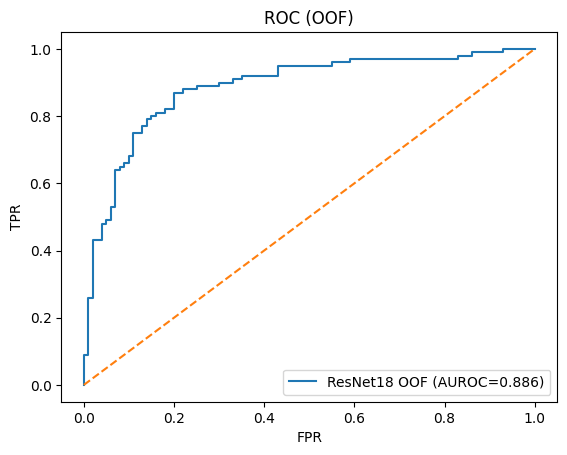

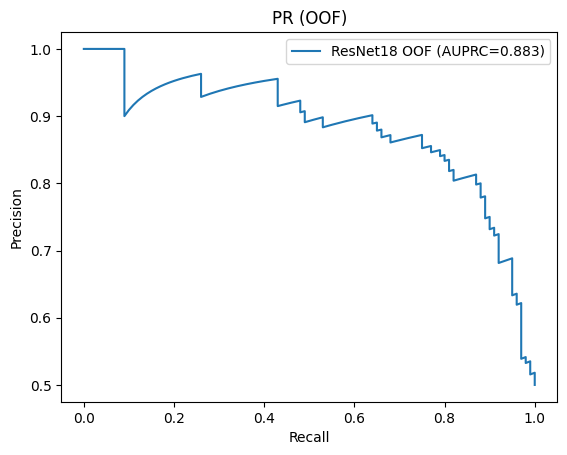

In [ ]:
auroc = roc_auc_score(work_df['label'], oof)
auprc = average_precision_score(work_df['label'], oof)
fpr, tpr, _ = roc_curve(work_df['label'], oof)
prec, rec, _ = precision_recall_curve(work_df['label'], oof)

import matplotlib.pyplot as plt
plt.figure(); plt.plot(fpr, tpr, label=f"ResNet18+Priors OOF (AUROC={auroc:.3f})"); plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (OOF)"); plt.legend(); plt.show()

plt.figure(); plt.plot(rec, prec, label=f"ResNet18+Priors OOF (AUPRC={auprc:.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("PR (OOF)"); plt.legend(); plt.show()


## Localization using GradCAM

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer="backbone.layer4"):
        self.model = model.eval()
        self.fmap, self.grad = None, None
        layer = dict(self.model.named_modules())[target_layer]
        layer.register_forward_hook(self._fhook)
        layer.register_full_backward_hook(self._bhook)
    def _fhook(self, m, i, o): self.fmap = o.detach()
    def _bhook(self, m, gi, go): self.grad = go[0].detach()
    @torch.no_grad()
    def _cam(self):
        w = self.grad.mean(dim=(2,3), keepdim=True)  # GAP on grads
        cam = (w * self.fmap).sum(1).clamp(min=0)[0].cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() + 1e-6)
        return cam
    def __call__(self, xb, tb):
        self.model.zero_grad()
        out = self.model(xb, tb)               # logits
        score = torch.sigmoid(out)
        idx = torch.argmax(score)
        out[idx].backward()
        return self._cam(), float(score[idx].item())

def localize_with_cam_priors(model, row, prior_cols, t_binary=0.4):
    path = row["image_path"]
    # Build eval image
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = pad_to_square(img); img = cv2.resize(img, (TARGET_SIZE, TARGET_SIZE), cv2.INTER_AREA)
    img = bg_suppress_and_stretch_numpy(img, t=20)
    img3 = np.stack([img,img,img], axis=-1)
    pil  = Image.fromarray(img3)
    t_eval = transforms.Compose([
        transforms.Resize(TARGET_SIZE), transforms.CenterCrop(TARGET_SIZE),
        transforms.ToTensor(), transforms.Normalize(mean=[0.5]*3, std=[0.25]*3),
    ])
    xb = t_eval(pil).unsqueeze(0).to(DEVICE)

    # Prior tensor
    tb_np = row[prior_cols].values.astype("float32")
    tb = torch.tensor(tb_np, dtype=torch.float32).unsqueeze(0).to(DEVICE)

    cammer = GradCAM(model)
    cam, prob = cammer(xb, tb)

    # Threshold CAM → largest blob → circle
    heat = (cam*255).astype(np.uint8)
    thr = max(1, int(255 * t_binary))
    mask = (heat >= thr).astype(np.uint8)*255
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8), iterations=1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8), iterations=1)

    nlab, labels = cv2.connectedComponents(mask)
    if nlab <= 1:
        center, radius = (TARGET_SIZE//2, TARGET_SIZE//2), 8
    else:
        areas = [(labels==i).sum() for i in range(1, nlab)]
        k = np.argmax(areas)+1
        ys, xs = np.where(labels==k)
        pts = np.stack([xs, ys], axis=1).astype(np.int32)
        (cx, cy), radius = cv2.minEnclosingCircle(pts.reshape(-1,1,2))
        center, radius = (int(cx), int(cy)), int(radius)

    base = (img3/255.0).copy()
    cm = cv2.applyColorMap((cam*255).astype(np.uint8), cv2.COLORMAP_JET)
    cm = cv2.cvtColor(cm, cv2.COLOR_BGR2RGB)/255.0
    overlay = (0.5*base + 0.5*cm).clip(0,1)
    cv2.circle(overlay, center, radius, (1.0,1.0,0.0), 2)
    return overlay, prob

## Test

In [ ]:
import matplotlib.pyplot as plt
final_model.eval()
idxs = np.random.choice(len(work_df), size=min(6, len(work_df)), replace=False)
plt.figure(figsize=(12,8))
for i, k in enumerate(idxs, 1):
    row = work_df.iloc[k]
    overlay, prob = localize_with_cam_priors(final_model, row, prior_cols, t_binary=0.4)
    gt = int(row["label"])
    plt.subplot(2,3,i); plt.imshow(overlay); plt.axis('off'); plt.title(f"p={prob:.2f} | GT={gt}")
plt.tight_layout(); plt.show()


UnboundLocalError: cannot access local variable 'cv2' where it is not associated with a value

<Figure size 1200x800 with 0 Axes>